# Federal Closure Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

# always be stylish
plt.style.use('ggplot')

## OPM Federal Closure Data

Read in the data, clean it a bit, make a few plots.

In [3]:
opm = pd.read_csv('./opm_snow_data.csv')

In [4]:
# rid unnecessary column...
opm.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# check 'er out
opm.head()

,year,date,notice
0,2017,"March 15, 2017",Open
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...
2,2016,"March 16, 2016",Open with Option for Unscheduled Leave or Unsc...
3,2016,"February 16, 2016",Open - 3 hours Delayed Arrival - With Option f...
4,2016,"February 9, 2016",Open with Option for Unscheduled Leave or Unsc...


### Clean the date values

In [6]:
# I remember scraping a messy date column (hence the "year" and "date" columns). Indeed, this will need some cleaning.
opm.date

0          March 15, 2017
1          March 14, 2017
2          March 16, 2016
3       February 16, 2016
4        February 9, 2016
5        January 29, 2016
6        January 28, 2016
7        January 27, 2016
8        January 26, 2016
9        January 25, 2016
10       January 22, 2016
11       January 22, 2016
12          March 6, 2015
13          March 5, 2015
14          March 3, 2015
15          March 2, 2015
16      February 26, 2015
17      February 18, 2015
18      February 17, 2015
19       January 27, 2015
20       January 26, 2015
21       January 21, 2015
22       January 14, 2015
23       January 12, 2015
24        January 6, 2015
25         March 17, 2014
26          March 4, 2014
27          March 3, 2014
28      February 26, 2014
29      February 14, 2014
              ...        
117          September 18
118              March 19
119              March 18
120           February 28
121           February 27
122           February 20
123           February 19
124         

In [7]:
# function to clean dates
# if there's a comma, convert to datetime and return
# if there's not a comma, grab month/day from something like 'January 27 (PM)' and concatenate with year. Return result
def convert_date(year, date):
    if ',' in date:
        return(pd.to_datetime(date))
    else:
        item = date.split(' (')[0]
        return(pd.to_datetime(str(item) + ', ' + str(year)))

In [8]:
# use function
opm['clean_date'] = opm.apply(lambda row: convert_date(row['year'], row['date']), axis=1)

In [9]:
# check...
print(opm.clean_date.min())
print(opm.clean_date.max())

1998-01-15 00:00:00
2026-12-25 20:03:00


In [10]:
# 2026?!
opm[opm.clean_date > '2017']

,year,date,notice,clean_date
0,2017,"March 15, 2017",Open,2017-03-15 00:00:00
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...,2017-03-14 00:00:00
115,2003,December 25 and 26,Closed,2026-12-25 20:03:00


In [11]:
# manually append Dec 25 and 26, 2003
opm.loc[len(opm)]=[2003, 'December 25', 'Closed', pd.to_datetime('December 25, 2003')]
opm.loc[len(opm)]=[2003, 'December 26', 'Closed', pd.to_datetime('December 26, 2003')]

In [12]:
# drop that ugly other one
opm.drop(opm.index[115], inplace=True)

In [13]:
# reindex
opm.reindex(copy=False)

,year,date,notice,clean_date
0,2017,"March 15, 2017",Open,2017-03-15
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...,2017-03-14
2,2016,"March 16, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-03-16
3,2016,"February 16, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-02-16
4,2016,"February 9, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-02-09
5,2016,"January 29, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-01-29
6,2016,"January 28, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-01-28
7,2016,"January 27, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-01-27
8,2016,"January 26, 2016",Federal Offices are Closed - Emergency and Tel...,2016-01-26
9,2016,"January 25, 2016",Federal Offices are Closed - Emergency and Tel...,2016-01-25


In [14]:
# check
opm.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            139, 140, 141, 142, 143, 144, 145, 146, 147, 148],
           dtype='int64', length=148)

In [15]:
opm.head()

,year,date,notice,clean_date
0,2017,"March 15, 2017",Open,2017-03-15
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...,2017-03-14
2,2016,"March 16, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-03-16
3,2016,"February 16, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-02-16
4,2016,"February 9, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-02-09


### Clean the notice texts

In [16]:
# how many different notices have they used over the years?
opm.notice.nunique()

27

In [17]:
# and what are they?
opm.notice.unique()

array(['Open',
       'Open - 3 hours Delayed Arrival - With Option for Unscheduled Leave or Unscheduled Telework',
       'Open with Option for Unscheduled Leave or Unscheduled Telework',
       "Federal Offices are Closed - Emergency and Telework-ready Employees Must Follow Their Agency's Policies",
       'FEDERAL OFFICES in the Washington, DC, area remain CLOSED.',
       'Open - with Option for Unscheduled Leave or Unscheduled Telework. 4 hours Staggered Early Departure - Employees Must Depart No Later Than 12:00 PM at Which Time Federal Offices are Closed',
       'Open - 2 hours Delayed Arrival - With Option for Unscheduled Leave or Unscheduled Telework',
       'Due to a lapse in appropriations, Federal government operations vary by agency.',
       'Open - Delayed Arrival - Employees should remain off the roads until 10:00 am. Federal offices will Open at 12:00 noon. Employees have the option for Unscheduled Leave or Unscheduled Telework.',
       'Open with option for Unsched

In [18]:
# how many closures?
print(opm[opm.notice == 'Closed'].shape[0])
opm[opm.notice == 'Closed']

13


,year,date,notice,clean_date
76,2010,February 11,Closed,2010-02-11
77,2010,February 10,Closed,2010-02-10
78,2010,February 9,Closed,2010-02-09
79,2010,February 8,Closed,2010-02-08
85,2009,"December 21, 2009",Closed,2009-12-21
116,2003,September 19,Closed,2003-09-19
117,2003,September 18,Closed,2003-09-18
119,2003,March 18,Closed,2003-03-18
124,2003,February 18,Closed,2003-02-18
136,2000,January 26,Closed,2000-01-26


In [19]:
# how many delays?
print(opm[opm.notice.str.contains('hours delayed', case=False, regex=False)].shape[0])
opm[opm.notice.str.contains('hours delayed', case=False, regex=False)]

13


,year,date,notice,clean_date
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...,2017-03-14
3,2016,"February 16, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-02-16
6,2016,"January 28, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-01-28
7,2016,"January 27, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-01-27
12,2015,"March 6, 2015",Open - 2 hours Delayed Arrival - With Option f...,2015-03-06
15,2015,"March 2, 2015",Open - 2 hours Delayed Arrival - With Option f...,2015-03-02
16,2015,"February 26, 2015",Open - 2 hours Delayed Arrival - With Option f...,2015-02-26
19,2015,"January 27, 2015",Open - 2 hours Delayed Arrival - With Option f...,2015-01-27
23,2015,"January 12, 2015",Open - 2 hours Delayed Arrival - With Option f...,2015-01-12
26,2014,"March 4, 2014",Open - 2 hours Delayed Arrival - With Option f...,2014-03-04


In [20]:
# get closure - like a convo with your ex
def get_closures(text):
    if 'Closed' in text:
        return 1
    else:
        return 0

In [21]:
# get delays - like an Amtrak
def get_delays(text):
    if 'hours Delayed' in text:
        return 1
    else:
        return 0

In [22]:
# get either - like...I dunno
strings = ("hours Delayed", "Closed")
def get_closures_delays(text):
    if any(s in text for s in strings):
        return 1
    else:
        return 0

In [23]:
# add columns for closures, delays, or either to dataset 
opm['closed']= opm.notice.apply(lambda text: get_closures(text))
opm['delayed'] = opm.notice.apply(lambda text: get_delays(text))
opm['delayed_or_closed'] = opm.notice.apply(lambda text: get_closures_delays(text))

In [24]:
opm.head()

,year,date,notice,clean_date,closed,delayed,delayed_or_closed
0,2017,"March 15, 2017",Open,2017-03-15,0,0,0
1,2017,"March 14, 2017",Open - 3 hours Delayed Arrival - With Option f...,2017-03-14,0,1,1
2,2016,"March 16, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-03-16,0,0,0
3,2016,"February 16, 2016",Open - 3 hours Delayed Arrival - With Option f...,2016-02-16,0,1,1
4,2016,"February 9, 2016",Open with Option for Unscheduled Leave or Unsc...,2016-02-09,0,0,0


In [25]:
opm_ts = opm.set_index('clean_date')

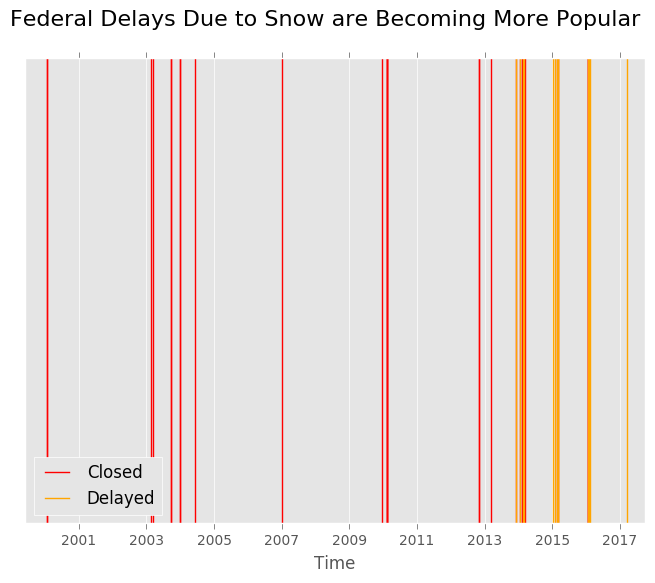

In [26]:
# plot closure/delays over time
fig, ax = plt.subplots()
plt.suptitle("Federal Delays Due to Snow are Becoming More Popular", size=16)
#plt.title("Closed or Delayed", size=12)
plt.xlabel('Time')
ax.vlines(x=(opm_ts[opm_ts['closed'] == 1].index), ymin=0, ymax=1, color='red', label='Closed')
ax.vlines(x=(opm_ts[opm_ts['delayed'] == 1].index), ymin=0, ymax=1, color='orange', label='Delayed')
plt.xlim(['1999-06', '2017-10'])
plt.yticks([])
plt.ylabel('')
plt.legend(loc='lower left')
plt.show()

## Google Search Volume Data

Read in the data, make a few plots.

In [27]:
# read in data
search = pd.read_csv('./google-trends-dc-snow.csv')
search.head()

,Week,snow: (District of Columbia)
0,3/25/12,3
1,4/1/12,3
2,4/8/12,3
3,4/15/12,3
4,4/22/12,4


In [28]:
# rename columns
search.rename(columns={'Week':'week', 'snow: (District of Columbia)':'volume'}, inplace=True)
search.head()

,week,volume
0,3/25/12,3
1,4/1/12,3
2,4/8/12,3
3,4/15/12,3
4,4/22/12,4


In [29]:
# format week column to datetime
search['week'] =  pd.to_datetime(search['week'])
# create timeseries
search_ts = search.set_index('week')

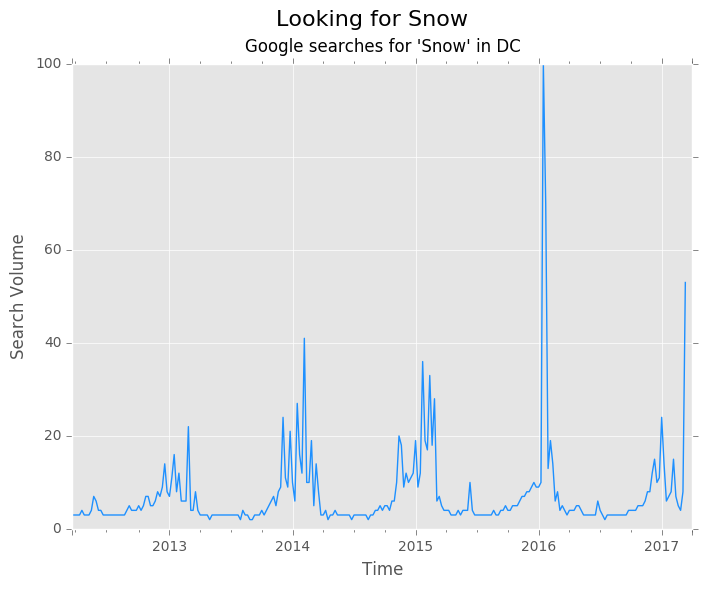

In [30]:
# plot it
search_ts.plot(color='dodgerblue', legend=None)
plt.suptitle("Looking for Snow", y=.99, size=16)
plt.title("Google searches for 'Snow' in DC", y=1.01, size=12)
plt.xlim([search_ts.index.min(), '2017-04'])
plt.xlabel('Time')
plt.ylabel('Search Volume')
plt.show()

In [31]:
# earliest search data?
search_ts.index.min()

Timestamp('2012-03-25 00:00:00')

In [32]:
# get federal data to match
opm_ts_12 = opm_ts['2012-03-25':]

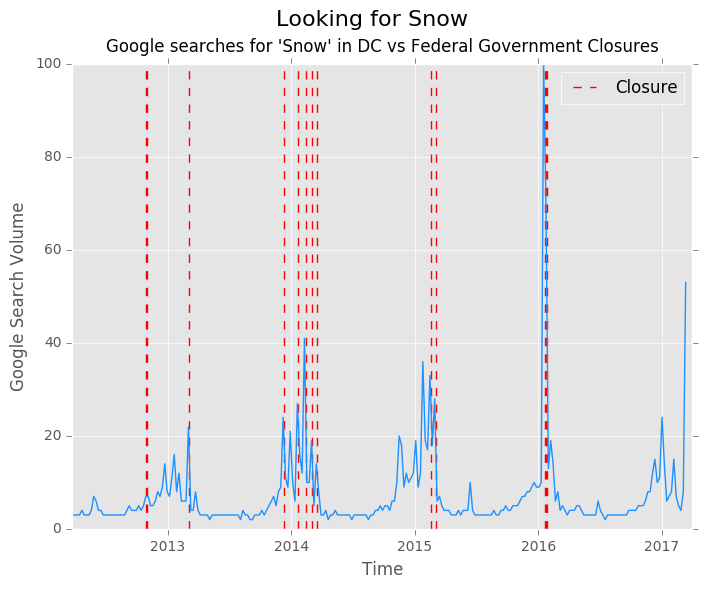

In [33]:
# plot snow searches vs snow closures
fig, ax = plt.subplots()
ax.vlines(x=(opm_ts_12[opm_ts_12['closed'] == 1].index), ymin=0, ymax=100, color='red', linestyles='dashed', label='Closure')
ax.plot(search_ts, color='dodgerblue')
plt.xlim([search_ts.index.min(), '2017-04'])

plt.suptitle("Looking for Snow", y=.99, size=16)
plt.title("Google searches for 'Snow' in DC vs Federal Government Closures", y=1.01, size=12)
plt.xlabel('Time')
plt.ylabel('Google Search Volume')
plt.legend(loc='best')
plt.show()

In [34]:
search.head()

,week,volume
0,2012-03-25,3
1,2012-04-01,3
2,2012-04-08,3
3,2012-04-15,3
4,2012-04-22,4
